## Introductie
In deze EDA ga ik de [hunting mantis](https://www.kaggle.com/datasets/stealthtechnologies/predict-hunting-success-rate-of-a-chinese-mantis) dataset onderzoeken, en een machine learning algoritme op trainen.
Uiteindelijk is het bedoeling om te kunnen voorspellen of een jacht van de mantis succesvol is gebasseerd op een aantal variabelen.
Om dit te kunnen doen zal de data eerst onderzocht moeten worden.





## EDA

In [41]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

### Inlezen

In [4]:
hunting_data = pd.read_csv("./data.csv")
hunting_data.index += 1
hunting_data.head()

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
1,0.32,31.25,Morning,True,0.81,6.600000,False,NaN,True,False,0
2,0.66,29.08,Afternoon,False,2.81,5.380000,False,Low,False,False,1
3,0.61,25.74,Evening,True,3.79,15.189246,True,Low,False,False,1
4,0.37,22.68,Morning,False,4.27,5.060000,True,Low,True,False,1
5,0.65,29.20,Afternoon,False,3.84,2.710000,False,High,False,False,1


In [5]:
hunting_data.shape

(300000, 11)

Alle kolommen en rijen zijn goed ingelezen, shape komt overeen met wat er op de site staat (300000x11).

In [6]:
codebook = {
    "attribute": hunting_data.columns,
    "unit": ["g/m^3", "Celcius", "NA", "True/False", "Minutes", "Cm", "True/False", "NA", "True/False", "True/False", "1/0"],
    "dtype": ["float64", "float64", "category", "bool", "float64", "float64", "bool", "category", "bool", "bool", "int64"],
    "description": [
        "Humidty level of enviroment",
        "Temperature of enviroment",
        "Time of the day",
        "Luring succes",
        "Time spent hunting",
        "Size of prey being hunted",
        "If mantis used an ambush",
        "Amount of food available",
        "If there are predators near",
        "If there is competition",
        "If the hunt was a succes"
    ]
}
pd.DataFrame(codebook)


,attribute,unit,dtype,description
0,Humidity Level,g/m^3,float64,Humidty level of enviroment
1,Temperature,Celcius,float64,Temperature of enviroment
2,Time of Day,NA,category,Time of the day
3,Luring Success,True/False,bool,Luring succes
4,Time Spent Hunting,Minutes,float64,Time spent hunting
5,Prey Size,Cm,float64,Size of prey being hunted
6,Ambush,True/False,bool,If mantis used an ambush
7,Food Availability,NA,category,Amount of food available
8,Predator Presence,True/False,bool,If there are predators near
9,Is Competition,True/False,bool,If there is competition


Deze dataframe bevat informatie over de attributen van de data

### Univariaat

In [7]:
pd.DataFrame({
  "isna": hunting_data.isna().sum()
})

hunting_data = hunting_data.dropna()


Er zijn een aantal missende waarden bij "Food Availability", "Predator Presence", "Is Competition". Ik wil later eerst bepalen hoe relevant deze waarden zijn voordat ik iets aan deze waarden ga doen.

In [8]:
def by_unit(*units):
    return [attribute for attribute, unit in zip(codebook["attribute"], codebook["unit"]) if unit in units]

In [9]:
hunting_data[by_unit("True/False")] = hunting_data[by_unit("True/False")].astype(int)


Om de distributies van numerieke attributen te visualiseren worden boxplotten en histogrammen gebruikt.

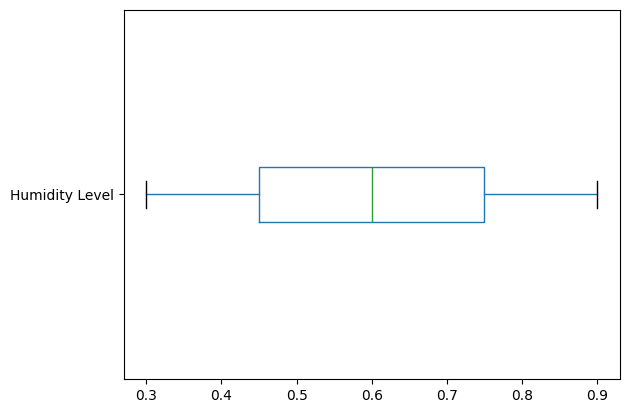

In [10]:
hunting_data[by_unit("g/m^3")].boxplot(vert=False, grid=False);

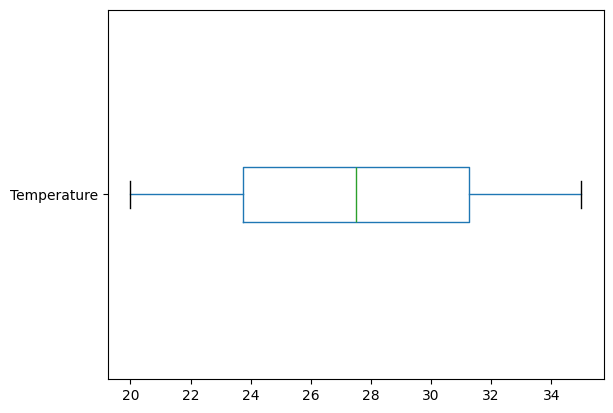

In [11]:
hunting_data[by_unit("Celcius")].boxplot(vert=False, grid=False);

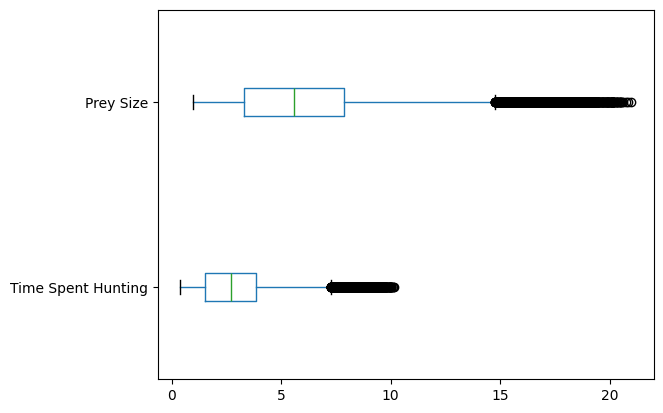

In [12]:
hunting_data[by_unit("Minutes", "Cm")].boxplot(vert=False, grid=False);

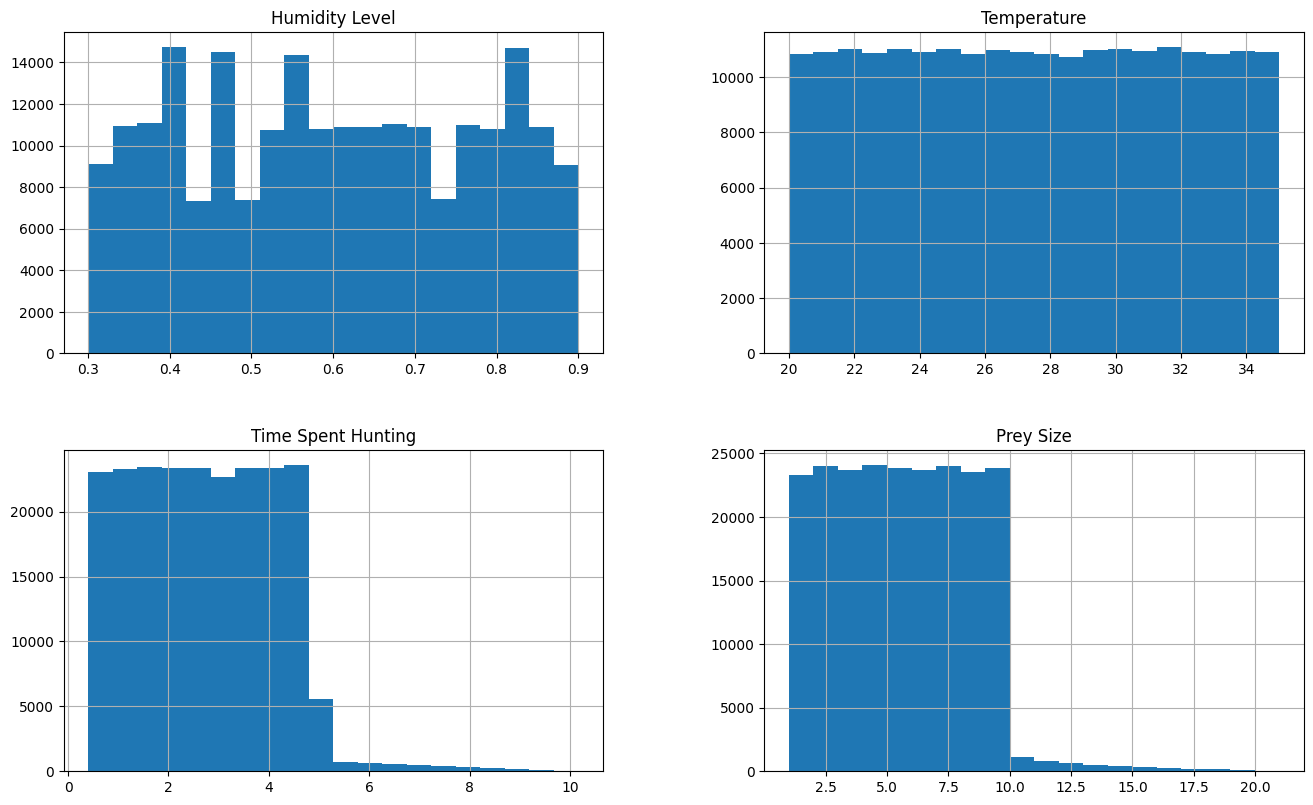

In [13]:
hunting_data[by_unit("g/m^3", "Celcius", "Minutes", "Cm")].hist(bins=20, layout=(2,2), figsize=(16,9.6));

Het is zichtbaar dat de data van temperatuur uniform verdeeld is.
Bij vochtigheid is het niet volledig univorm, sommige nummers komen iets vaker voor dan andere.
De laatste 2 zijn vrij univorm verdeeld, tot een bepaalde waarde (=>5 bij time spent hunting, => 10 bij Prey size). Dit wijst erop dat over het algemeen er minder dan 5 minuten gejaagd wordt. Grotere prooien komen minder vaak voor, wat kan wijzen naar een voorkeur van de mantis.

Ik wil nu de distributies vergelijken van de categorische attributen, "Time of Day" en "Food Availability". Dit wordt gedaan met een barchart

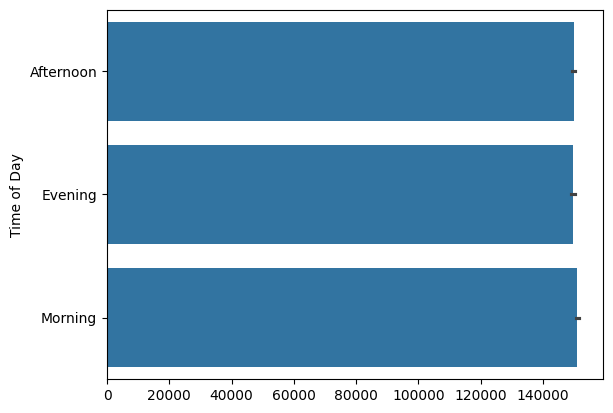

In [14]:
sns.barplot(hunting_data["Time of Day"]);

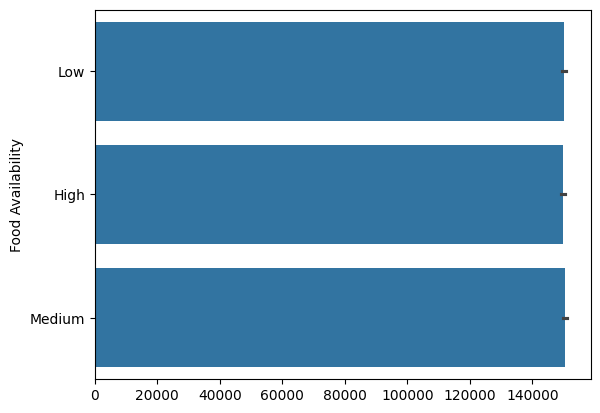

In [15]:
sns.barplot(hunting_data["Food Availability"]);

De 2 categorische features: "Food Availability" en "Time of Day" zijn ook uniform verdeeld


<Axes: >

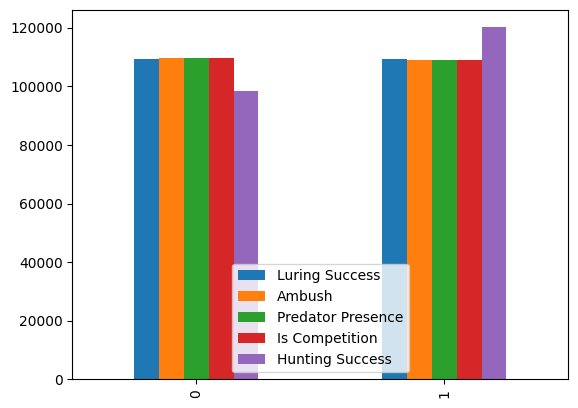

In [16]:
hunting_data[by_unit("True/False", "1/0")].apply(pd.Series.value_counts).plot(kind="bar")

De boolean features zijn ook uniform verdeeld. De verdeling tussen wel en niet is gelijk. Bij hunting success is er zichtbaar dat een geslaagde jacht iets meer voorkomt.

## Bivariate
Ik ga nu kijken naar hoe de continue data: humidity,Temperature, prey size, en time spend hunting in verhouding staat met of een jacht succesvol was of niet.

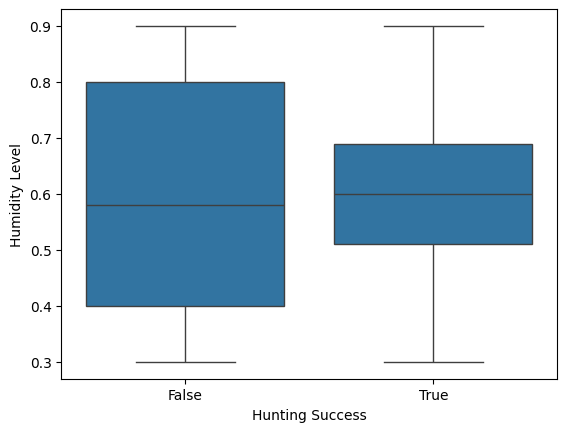

In [17]:
sns.boxplot(y=hunting_data["Humidity Level"], x=hunting_data["Hunting Success"].astype(bool));

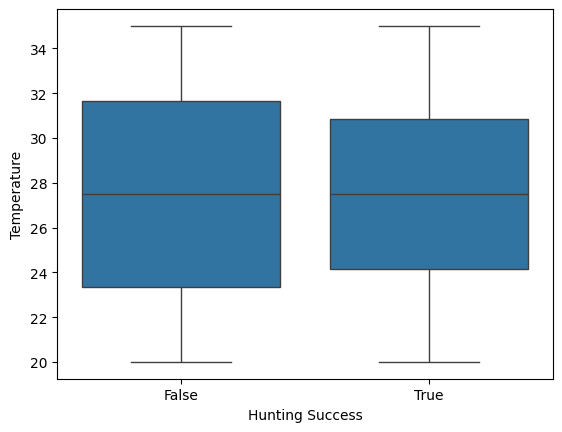

In [18]:
sns.boxplot(y=hunting_data["Temperature"], x=hunting_data["Hunting Success"].astype(bool));

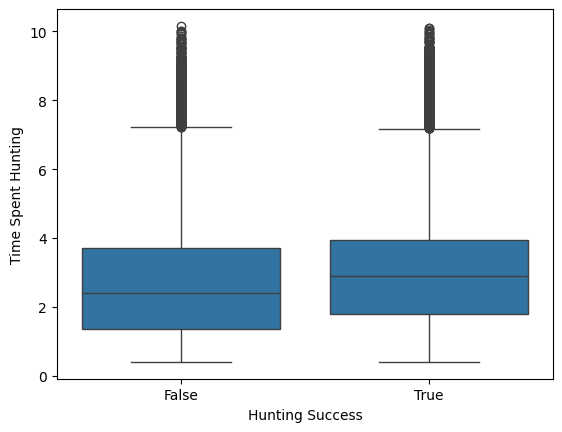

In [19]:
sns.boxplot(y=hunting_data["Time Spent Hunting"], x=hunting_data["Hunting Success"].astype(bool));

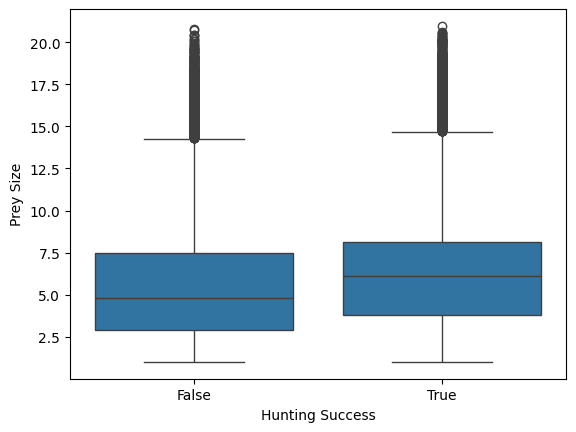

In [20]:
sns.boxplot(y=hunting_data["Prey Size"], x=hunting_data["Hunting Success"].astype(bool));

De IQR van de humidity bij een succesvolle jacht is een stuk kleiner dan bij een niet succesvolle jacht. Dit kan weergeven dat er een optimale vochtigheid is om te gaan jagen.
Bij de andere 3 plotjes komen de boxplotjes wel overeen. Bij Time Spend Hunting en Prey Size ligt de IQR een klein beetje hoger bij een succesvolle jacht, om te bekijken of dit significant is ga ik een two-sample Kolmogorov-Smirnov test uitvoeren. Een t-test zou niet werken, de data is niet normaal verdeeld.


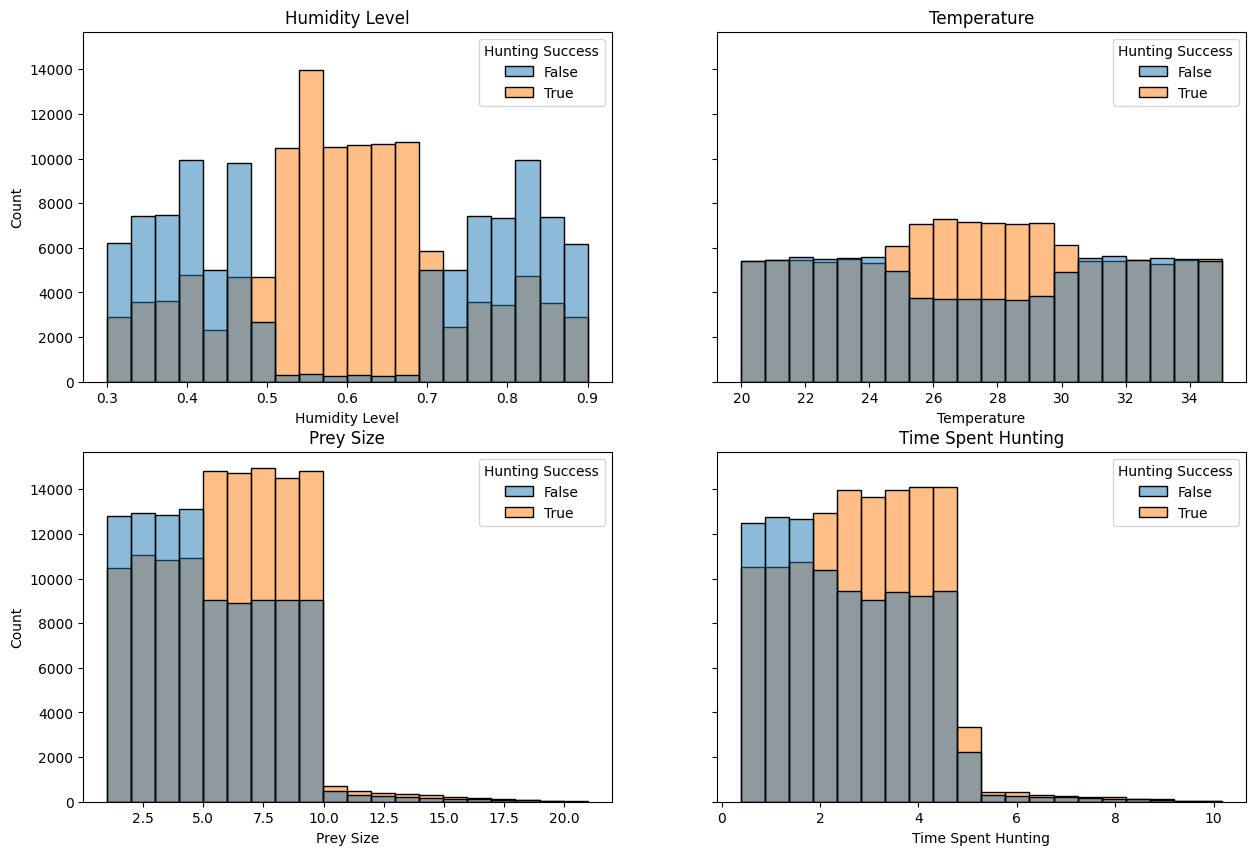

In [71]:
wanted_columns = ["Humidity Level", "Temperature", "Prey Size", "Time Spent Hunting"]

fix, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10));
index = 0
for i in range(0, 2):
    for j in range(0,2):
        sns.histplot(ax = axes[i,j], x=hunting_data[wanted_columns[index]], hue=hunting_data["Hunting Success"].astype(bool), bins=20,multiple='layer');
        axes[i,j].set_title(wanted_columns[index])
        index += 1

Dit geeft weer dat er een optimale vochtigheid en temperatuur blijkt te zijn voor het jagen. Het aantal succesvolle jachten stijgt tussen een vochtigheid van 0.5 en 0.7 G/m^3 en ook bij een temperatuur van 25-28 graden celcius.
Bij time spent hunting en prey size loopt het aantal succesvolle jachten ook een beetje op, maar minder.

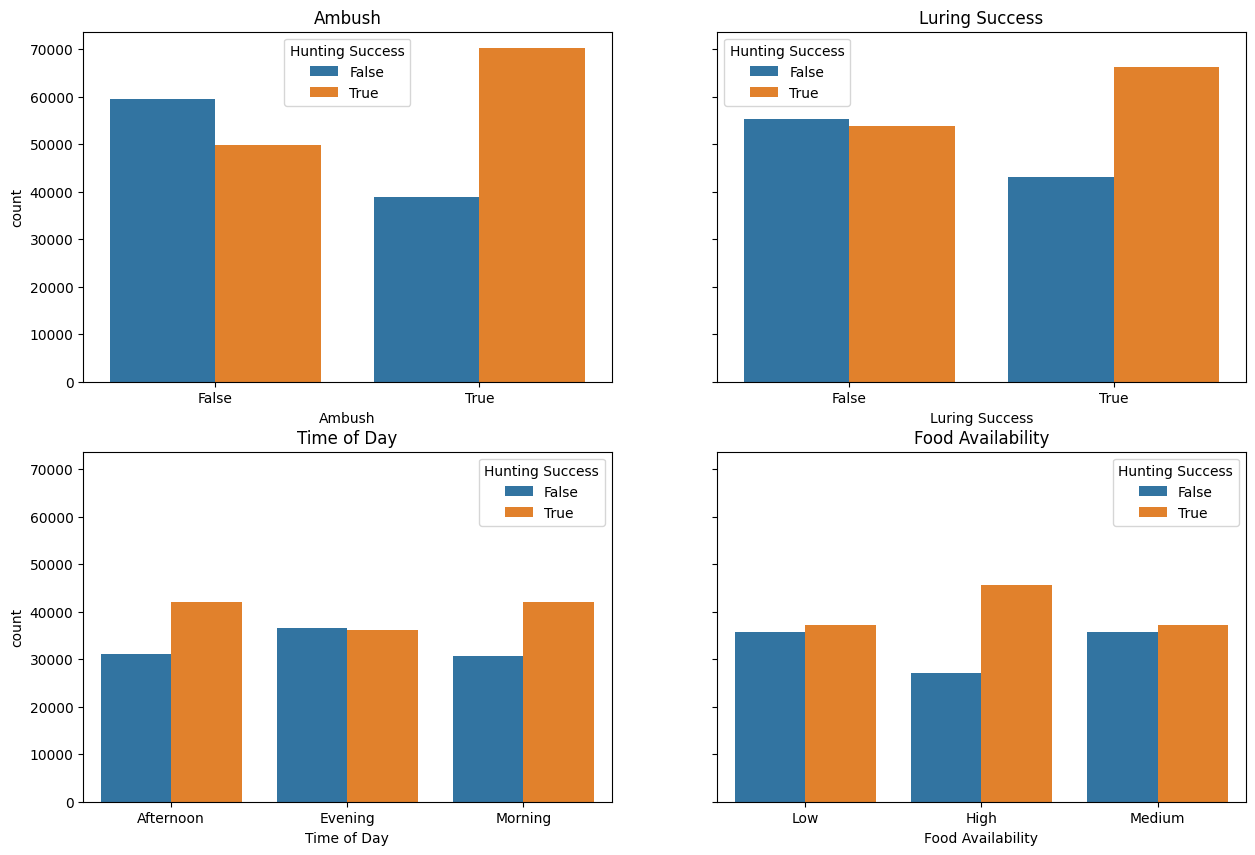

In [22]:
wanted_columns = ["Ambush", "Luring Success", "Time of Day", "Food Availability"]

fix, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10));
index = 0

for i in range(0,2):
    for j in range(0,2):
        ft = codebook["attribute"].to_list().index(wanted_columns[index])
        if codebook["dtype"][ft] == "bool":
            sns.countplot(ax = axes[i,j], x = hunting_data[wanted_columns[index]].astype(bool), hue = hunting_data["Hunting Success"].astype(bool));
        else:
            sns.countplot(ax = axes[i,j], x = hunting_data[wanted_columns[index]], hue = hunting_data["Hunting Success"].astype(bool));
        axes[i,j].set_title(wanted_columns[index])
        index += 1

conclusie:
* Het aantal succesvolle jachten stijgt bij:
    - Wanneer een ambush is toegepast
    - Wanneer luring succesvol is
    - Tijdens de ochtend en de namiddag
    - Wanneer er veel voedsel aanwezig is




In [60]:
import scipy.stats as stats

table = pd.crosstab(hunting_data.Ambush, hunting_data["Hunting Success"])
table

Hunting Success,0,1
Ambush,,
0,59614,49903
1,38907,70168


In [61]:
chi2, p, dof, expected = stats.chi2_contingency(table.to_numpy(), correction=False)
p

np.float64(0.0)

De p-waarde is 0, wat inhoudt dat de waarde van ambush invloed heeft op de waarde van hunting succes.

In [25]:
table = pd.crosstab(hunting_data["Time of Day"], hunting_data["Hunting Success"])
table

Hunting Success,0,1
Time of Day,,
Afternoon,31188,42009
Evening,36590,36120
Morning,30743,41942


In [26]:
res = stats.chi2_contingency(table, correction=False)
res.pvalue

np.float64(1.1187086815472177e-264)

p < 0.5, en dus heeft de time of day ook invloed op een succesvolle jacht.

Omdat de verhoudingen niet linear zijn kan ik niet gebruik maken van een normale correlatie matrix.
Wel kan ik gebruik maken van een mutual info classifier (MIC) deze zal algemene afhankelijkheden weergeven voor een gekozen variabele (hunting success)

In [99]:
from sklearn.feature_selection import mutual_info_classif
one_hot_food = pd.get_dummies(hunting_data["Food Availability"])
one_hot_time = pd.get_dummies(hunting_data["Time of Day"])
X = hunting_data.drop(["Time of Day", "Food Availability", "Hunting Success"], axis=1).join([one_hot_food, one_hot_time])
y = hunting_data["Hunting Success"]
mi = mutual_info_classif(X,y)
mi_df = pd.DataFrame(mi, index=X.columns, columns=["MI"])
mi_df


,MI
Humidity Level,0.239378
Temperature,0.009654
Luring Success,0.025157
Time Spent Hunting,0.010045
Prey Size,0.014976
Ambush,0.037984
Predator Presence,0.019845
Is Competition,0.019256
High,0.014211
Low,0.009181


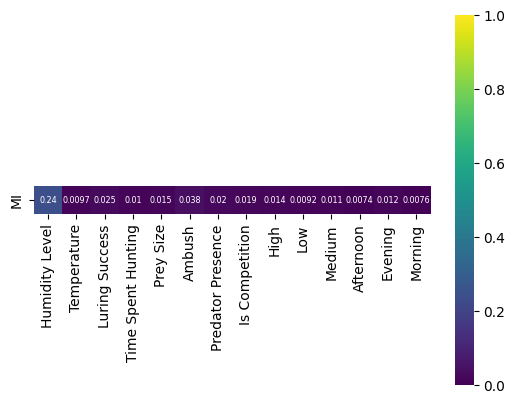

In [101]:
axs = sns.heatmap(mi_df.T, annot=True, annot_kws={"fontsize": "xx-small"}, cmap="viridis", vmin=0.0, vmax=1.0, square=True)

conclusie:  
- Humidity heeft de hoogste MI score van 0.24
- Ambush heeft een kleine significantie, kleiner dan humidty
- Luring success heeft ook een kleine significantie
- De time of day blijkt niet veel impact te hebben

In [109]:
X = hunting_data[by_unit("g/m^3", "Celcius", "True/False", "Cm")].to_numpy()
y = hunting_data["Hunting Success"].to_numpy()

,Humidity Level,Temperature,Luring Success,Prey Size,Ambush,Predator Presence,Is Competition
2,0.66,29.08,0,5.380000,0,0,0
3,0.61,25.74,1,15.189246,1,0,0
4,0.37,22.68,0,5.060000,1,1,0
5,0.65,29.20,0,2.710000,0,0,0
7,0.86,29.92,0,6.320000,0,0,0
...,...,...,...,...,...,...,...
299995,0.76,33.53,1,2.520000,0,0,1
299996,0.65,24.36,0,2.870000,1,1,1
299997,0.37,26.94,0,9.770000,1,1,0
299998,0.88,20.17,1,5.170000,1,0,0


In [120]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

models = [
    DummyClassifier,
    DecisionTreeClassifier,
    GaussianNB,
    KNeighborsClassifier,
    RandomForestClassifier
]

In [111]:
from sklearn.model_selection import cross_validate

metric_scores = {}
for model in models:
    scores = cross_validate(model(), X, y, return_train_score=True)
    for key, val in scores.items():
        scores[key] = val.mean()
    metric_scores[f"{model.__name__}"] = scores
    
pd.DataFrame(metric_scores).T

,fit_time,score_time,test_score,train_score
DummyClassifier,0.015491,0.001551,0.549293,0.549293
DecisionTreeClassifier,0.917611,0.021503,0.826110,0.999993
GaussianNB,0.054763,0.007453,0.715516,0.715728
KNeighborsClassifier,0.600999,4.556819,0.741354,0.837318
RandomForestClassifier,26.292009,1.711436,0.857895,0.999979


Conclusie:  
- Dummy is zo goed als 50/50, wat logisch is omdat deze random kiest.
- DescisionTree Heeft een zeer hoge train score, en is waarschijnlijk aan het overfitten
- GaussianNB heeft een vrijwel gelijke test en train score, en lijkt stabiel te zijn
- KNeighbors heeft een iets hogere train_score dan de test score, en kan mogelijk een beetje aan het overfitten zijn.
- RandomForsst is ook aan het overfitten, en duurt veel langer over het fitten dan de rest.
  
Ik wil voor elk model kijken naar hyper-parameters/functies om te kijken of we deze minder kunnen laten overfitten.

Eerst de DecisionTree
Ik wil kijken naar de max-depth, minimale-sample-split, min-sample-leaf.
Dit kan ik doen met de GridSearchCV functie.

In [ ]:
from sklearn.model_selection import GridSearchCV
params_df = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 10],
}

dt_model = DecisionTreeClassifier(random_state=42)

gs_result = GridSearchCV(dt_model, params_df, scoring="accuracy")
gs_result.fit(X, y)

print(f"Beste parameters: {gs_result.best_params_}")

Beste parameters: {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 20}


Hieruit blijken de volgende parameters het beste:
- max-depth: 7
- min_samples_leaf: 5
- min_samples_split: 20

Nu wil ik kijken naar KNeighbors waar ik in ieder geval n_neighbors wil bekijken

In [119]:
params_df = {
    "n_neighbors": [3, 5, 7, 10, 15, 20, 30]
}

KN_model = KNeighborsClassifier()

gs_result = GridSearchCV(KN_model, params_df, scoring="accuracy")
gs_result.fit(X, y)

print(f"Beste parameters: {gs_result.best_params_}")

Beste parameters: {'n_neighbors': 3}


Hier komt dat de beste parameter voor n_neighrs 3 is.

Voor de RandomForest wil ik kijken naar:
n_estimators,
max_depth,


In [122]:
params_df = {
    "n_estimators": [100, 125, 150, 175, 200],
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 10],
}

RF_model = RandomForestClassifier()



gs_result = GridSearchCV(RF_model, params_df, scoring="accuracy", n_jobs=-1)
gs_result.fit(X, y)

print(f"Beste parameters: {gs_result.best_params_}")

Beste parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}


In [135]:
models = {
    "DummyClassifier": DummyClassifier,
    "DecisionTreeClassifier": DecisionTreeClassifier,
    "GaussianNB": GaussianNB,
    "KNeighborsClassifier": KNeighborsClassifier,
    "RandomForestClassifier": RandomForestClassifier
}

best_params = {
    "DummyClassifier": {},
    "DecisionTreeClassifier": {"max_depth": 4, "min_samples_leaf": 5, "min_samples_split": 20},
    "GaussianNB": {},
    "KNeighborsClassifier": {"n_neighbors": 3},
    "RandomForestClassifier": {"max_depth": 10, "min_samples_leaf": 10, "min_samples_split": 20, "n_estimators": 200}
}

In [ ]:
metric_scores = {}
for model_name, model in models.items():
    model().set_params(**best_params[model_name])
    scores = cross_validate(model(), X, y, return_train_score=True, n_jobs=-1)
    for key, val in scores.items():
        scores[key] = val.mean()
    metric_scores[f"{model.__name__}"] = scores
    
pd.DataFrame(metric_scores).T

,fit_time,score_time,test_score,train_score
DummyClassifier,0.033928,0.002030,0.549293,0.549293
DecisionTreeClassifier,1.269991,0.029239,0.826064,0.999993
GaussianNB,0.090229,0.012201,0.715516,0.715728
KNeighborsClassifier,0.692720,6.043527,0.741354,0.837318
RandomForestClassifier,28.539914,1.534883,0.857950,0.999976
